# TimeSeries DataAnalytics Tutorial



In [1]:
%matplotlib inline

import visdom
import numpy as np
import chart_studio.plotly as py
import plotly.express as px
import plotly.tools as tls
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import pandas as pd
from datetime import datetime
import requests
import json
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append("../TimeSeriesTools")
import mongodb_utils
db_host= 'localhost'
port = '27018'
db_name='TimeSeriesBench'
mongodb_client = mongodb_utils.mongodb_connect(db_host, port)

Trying to connect to MongoDB server: localhost on port: 27018


In [ ]:
import kairosdb_utils
global kairosdb_server 
kairosdb_server = "http://localhost:9080"

In [ ]:
import influxdb_utils
db_host= 'localhost'
port = '8086'
db_name='TimeSeriesBench'
influxdb_client = influxdb_utils.influxdb_connect(db_host, port)

In [3]:
def get_collection_scheme(db_name,scheme_name):
    db = mongodb_client[db_name]
    schemes_coll = db['schemes']
    scheme = schemes_coll.find({"name":scheme_name})
    return scheme

In [4]:
def mongodb_find_all_data(db_name,coll_name,scheme):
    data = mongodb_utils.get_all_data(mongodb_client,db_name,coll_name,scheme)
    return data

In [5]:
def mongodb_find_data_select_by_tags(db_name,coll_name,tags,scheme):
    data = mongodb_utils.get_data_select_by_tags(mongodb_client,db_name,coll_name,tags,scheme)
    return data

In [ ]:
def kairosdb_find_all_data(db_name,coll_name,scheme):
    data = kairosdb_utils.get_all_data(kairosdb_server,db_name,coll_name,scheme)
    return data

In [ ]:
def influxdb_find_all_data(db_name,coll_name,scheme):
    data = influxdb_utils.get_all_data(influxdb_client,db_name,coll_name,scheme)
    return data

In [6]:
def clean_data(scheme,data):
    from cerberus import Validator
    v = Validator(scheme)
    for index,item in enumerate(data,start=0):
        res = v.validate(item)
        if (res == False):
            print("corrupt data in line :",index,", error : ",v.errors)
            del data[index]

In [7]:
def str_to_unix(date):
    dt = datetime.strptime(date, '%d/%m/%Y %H:%M:%S')
    epoch = datetime.utcfromtimestamp(0)
    return int((dt - epoch).total_seconds()) * 1000

In [8]:
def to_unix_time(dt):
    epoch =  datetime.utcfromtimestamp(7200)
    return (dt - epoch).total_seconds() * 1000

In [19]:
def str_to_timestamp(date):
    dt = datetime.strptime(date, '%d/%m/%Y %H:%M:%S')
    d0 = datetime(2019,1,1,0,0,0,0)
    return int((dt - d0).total_seconds())

In [9]:
def type_convert(df):
    head = df.columns
    for i in range(1,len(head)) : 
        df[head[i]] = pd.to_numeric(df[head[i]])

## I/ Requete des données

### A/ Données SmartGrid

In [10]:
scheme = get_collection_scheme(db_name,'SmartGrid')

In [11]:
scheme[0]['value']

{'_id': {'required': True},
 'timestamp': {'type': 'string', 'required': True, 'empty': False},
 'tagname': {'type': 'string', 'required': True, 'empty': False},
 'value': {'type': 'string', 'required': True, 'empty': False},
 'quality': {'type': 'string', 'required': True, 'empty': False}}

In [16]:
%%time
coll_name='SmartGridCryolite20190101OneMonthBS10000d'
data = mongodb_find_all_data(db_name,coll_name,scheme[0]['value'])
print("number of docs",len(data))

769598  documents found
number of docs 769598
CPU times: user 3.31 s, sys: 317 ms, total: 3.62 s
Wall time: 3.88 s


In [13]:
%%time
coll_name='SmartGridCryolite20190101OneMonthBS10000d'
tags = { 'Buiding' : 'CRY', 'Device' : 'CENTRALE_SOLAIRE', 'Measure' : 'CRY_act_prod_pow' }
data = mongodb_find_data_select_by_tags(db_name,coll_name,tags,scheme[0]['value'])
print("number of docs",len(data))

27584  documents found
number of docs 27584
CPU times: user 258 ms, sys: 73.4 ms, total: 331 ms
Wall time: 625 ms


In [ ]:
%%time
clean_data(scheme[0]['value'],data)

In [17]:
%%time
df = pd.DataFrame(data)
df[0:5]

CPU times: user 898 ms, sys: 22.9 ms, total: 921 ms
Wall time: 919 ms


_id            timestamp  \
0  5ee31951b4320c151b0560db  01/01/2019 09:15:12   
1  5ee31951b4320c151b0560dc  01/01/2019 09:15:18   
2  5ee31951b4320c151b0560dd  01/01/2019 09:15:37   
3  5ee31951b4320c151b0560de  01/01/2019 09:15:43   
4  5ee31951b4320c151b0560df  01/01/2019 09:15:53   

                                 tagname        value quality  
0  CRY.CENTRALE_SOLAIRE.CRY_act_prod_pow  1.000000000   100.0  
1  CRY.CENTRALE_SOLAIRE.CRY_act_prod_pow  0.000000000   100.0  
2  CRY.CENTRALE_SOLAIRE.CRY_act_prod_pow  1.000000000   100.0  
3  CRY.CENTRALE_SOLAIRE.CRY_act_prod_pow  0.000000000   100.0  
4  CRY.CENTRALE_SOLAIRE.CRY_act_prod_pow  1.000000000   100.0

In [18]:
df.tagname.unique()

array(['CRY.CENTRALE_SOLAIRE.CRY_act_prod_pow',
       'CRY.CENTRALE_SOLAIRE.CRY_app_prod_pow',
       'CRY.CENTRALE_SOLAIRE.CRY_rea_prod_pow',
       'CRY.TGBT_NORMAL.CRY_act_cons_pow',
       'CRY.TGBT_NORMAL.CRY_app_cons_pow',
       'CRY.TGBT_NORMAL.CRY_rapp_cons_ene',
       'CRY.TGBT_NORMAL.CRY_rea_cons_pow'], dtype=object)

In [20]:
df['timestamp'] = df['timestamp'].apply(str_to_timestamp)

In [21]:
df['day-id'] = df['timestamp']//(3600*24)

In [22]:
df['hour-id'] = df['timestamp'] % (3600*24) // 3600

In [23]:
df['hour-id'].unique()

array([ 9, 10, 11, 12, 13, 14, 15, 16,  8, 17,  7,  0,  1,  2,  3,  4,  5,
        6, 18, 19, 20, 21, 22, 23])

In [24]:
df['value'] = pd.to_numeric(df['value'])
df['hour-id'] = pd.to_numeric(df['hour-id'])

In [25]:
import matplotlib.colors as mcolors
color_names = [ c for c in mcolors.CSS4_COLORS.keys()]

In [26]:
def compute_curve(df,day_id,tagname):
    day_df = df.loc[(df['day-id'] == day_id) & (df['tagname'] == tagname )]
    vh_df = day_df[['hour-id','value']].groupby('hour-id').mean().reset_index().sort_values(by='hour-id')
    x = vh_df['hour-id']
    y = vh_df['value']
    return x,y

def plot_curve(df,day_id,tagname,color_names,fig):
    x , y = compute_curve(df,day_id,tagname)
    nb_points = len(x)
    fig.add_trace(go.Scatter(x=x,y=y,name="Value"+tagname+"Day"+str(day_id),
                            line_color=color_names[day_id],
                            opacity=0.8))
    # Use date string to set xaxis range
    fig.update_layout(title_text="day smartgrid data series")
    

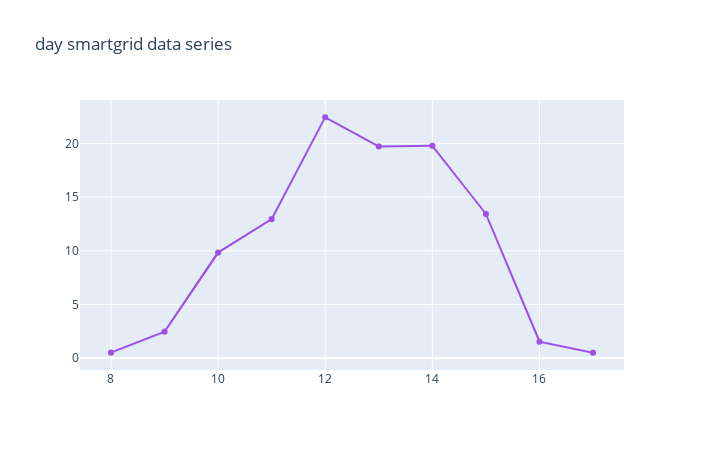

CPU times: user 222 ms, sys: 35.2 ms, total: 258 ms
Wall time: 2.06 s


In [27]:
%%time
day_id = 10
tagname = 'CRY.CENTRALE_SOLAIRE.CRY_act_prod_pow'
fig = go.Figure()
plot_curve(df,day_id,tagname,color_names,fig)
fig.show()

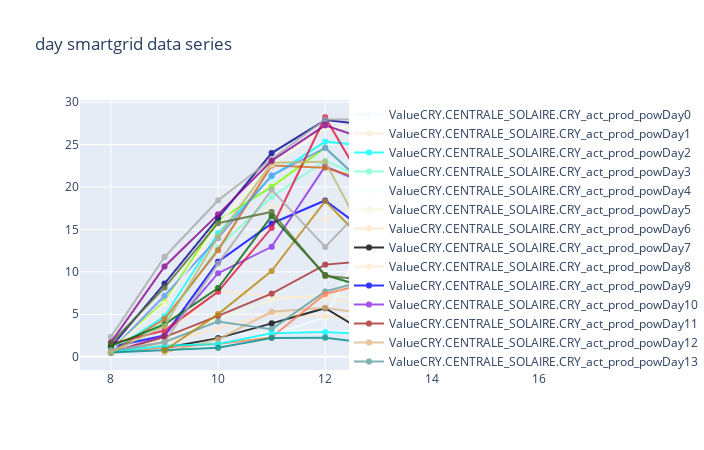

CPU times: user 1.51 s, sys: 2.8 ms, total: 1.51 s
Wall time: 1.5 s


In [28]:
%%time
fig = go.Figure()
for day_id in range(30):
    plot_curve(df,day_id,tagname,color_names,fig)
fig.show()

In [29]:
def plot_curve(df,day_id,tag_id,tagname,color_names,fig):
    x , y = compute_curve(df,day_id,tagname)
    nb_points = len(x)
    fig.add_trace(go.Scatter(x=x,y=y,name="Value"+tagname+"Day"+str(day_id),
                            line_color=color_names[day_id],
                            opacity=0.8),
                  row=tag_id+1,col=1)
    # Use date string to set xaxis range
    fig.update_layout(title_text="day smartgrid data series")

### B/ Données Eolienne

In [30]:
scheme = get_collection_scheme(db_name,'WindPropLacqV5')

In [31]:
scheme[0]['value']

{'_id': {'required': True},
 'Heure': {'type': 'string', 'required': True, 'empty': False},
 'Temps écoulé': {'type': 'string', 'required': True, 'empty': False},
 '4069 state': {'type': 'string', 'required': True, 'empty': False},
 'Battery voltage': {'type': 'string', 'required': True, 'empty': False},
 'Flow SP': {'type': 'string', 'required': True, 'empty': False},
 'Unit Code': {'type': 'string', 'required': True, 'empty': False},
 'Flow M': {'type': 'string', 'required': True, 'empty': False},
 'Pressure1': {'type': 'string', 'required': True, 'empty': False},
 'Temperature1': {'type': 'string', 'required': True, 'empty': False},
 'Latitude': {'type': 'string', 'required': True, 'empty': False},
 'Longitude': {'type': 'string', 'required': True, 'empty': False},
 'Altitude': {'type': 'string', 'required': True, 'empty': False},
 'Head_Rel_True North': {'type': 'string', 'required': True, 'empty': False},
 'Pressure2': {'type': 'string', 'required': True, 'empty': False},
 'Temper

In [32]:
coll_name='WindPropLacqOneDayP25'

In [33]:
%%time
data = mongodb_find_all_data(db_name,coll_name,scheme[0]['value'])
print("number of docs",len(data))

7200  documents found
number of docs 7200
CPU times: user 233 ms, sys: 14 ms, total: 247 ms
Wall time: 469 ms


In [ ]:
%%time
data = kairosdb_find_all_data(db_name,coll_name,scheme[0]['value'])
print("number of docs",len(data))

In [ ]:
%%time
data = influxdb_find_all_data(db_name,coll_name,scheme[0]['value'])
print("number of docs",len(data))

In [ ]:
%%time
clean_data(scheme[0]['value'],data)

In [34]:
%%time
df = pd.DataFrame(data)
df[0:5]

CPU times: user 174 ms, sys: 7.05 ms, total: 181 ms
Wall time: 178 ms


_id                Heure Temps écoulé 4069 state  \
0  5edccb0bfbce0deabbf7e5aa  02/10/2019 09:11:02            0   1.010000   
1  5edccb0bfbce0deabbf7e5ab  02/10/2019 09:11:03            1   1.010000   
2  5edccb0bfbce0deabbf7e5ac  02/10/2019 09:11:04            2   1.010000   
3  5edccb0bfbce0deabbf7e5ad  02/10/2019 09:11:05            3   1.010000   
4  5edccb0bfbce0deabbf7e5ae  02/10/2019 09:11:06            4   1.010000   

  Battery voltage Flow SP Unit Code Flow M Pressure1 Temperature1  ...  C2H6  \
0       888888.00    9.00     17.00   0.00     1.008       19.933  ...  0.00   
1       888888.00    9.00     17.00   0.00     1.008       19.955  ...  0.00   
2       888888.00    9.00     17.00   0.00     1.008       19.955  ...  0.00   
3       888888.00    9.00     17.00   0.00     1.008       19.944  ...  0.00   
4       888888.00    9.00     17.00   0.00     1.008       19.944  ...  0.00   

  C2H6_dry 13CH4   H2O   CO2 C2C1Ratio Delta_iCH4_Raw HP_Delta_iCH4_30s  \
0     0.00  0.00  0.00  0.00      0.00           0.00              0.00   
1     0.00  0.00  0.00  0.00      0.00           0.00              0.00   
2     0.00  0.00  0.00  0.00      0.00           0.00              0.00   
3     0.00  0.00  0.00  0.00      0.00           0.00              0.00   
4     0.00  0.00  0.00  0.00      0.00           0.00              0.00   

  HP_Delta_iCH4_2min HP_Delta_iCH4_5min  
0               0.00               0.00  
1               0.00               0.00  
2               0.00               0.00  
3               0.00               0.00  
4               0.00               0.00  

[5 rows x 52 columns]

In [35]:
df['Heure'] = df['Heure'].apply(str_to_unix)
df[0:5]

_id          Heure Temps écoulé 4069 state  \
0  5edccb0bfbce0deabbf7e5aa  1570007462000            0   1.010000   
1  5edccb0bfbce0deabbf7e5ab  1570007463000            1   1.010000   
2  5edccb0bfbce0deabbf7e5ac  1570007464000            2   1.010000   
3  5edccb0bfbce0deabbf7e5ad  1570007465000            3   1.010000   
4  5edccb0bfbce0deabbf7e5ae  1570007466000            4   1.010000   

  Battery voltage Flow SP Unit Code Flow M Pressure1 Temperature1  ...  C2H6  \
0       888888.00    9.00     17.00   0.00     1.008       19.933  ...  0.00   
1       888888.00    9.00     17.00   0.00     1.008       19.955  ...  0.00   
2       888888.00    9.00     17.00   0.00     1.008       19.955  ...  0.00   
3       888888.00    9.00     17.00   0.00     1.008       19.944  ...  0.00   
4       888888.00    9.00     17.00   0.00     1.008       19.944  ...  0.00   

  C2H6_dry 13CH4   H2O   CO2 C2C1Ratio Delta_iCH4_Raw HP_Delta_iCH4_30s  \
0     0.00  0.00  0.00  0.00      0.00           0.00              0.00   
1     0.00  0.00  0.00  0.00      0.00           0.00              0.00   
2     0.00  0.00  0.00  0.00      0.00           0.00              0.00   
3     0.00  0.00  0.00  0.00      0.00           0.00              0.00   
4     0.00  0.00  0.00  0.00      0.00           0.00              0.00   

  HP_Delta_iCH4_2min HP_Delta_iCH4_5min  
0               0.00               0.00  
1               0.00               0.00  
2               0.00               0.00  
3               0.00               0.00  
4               0.00               0.00  

[5 rows x 52 columns]

In [36]:
type_convert(df)

In [37]:
df['MDA Wnd Speed'].describe()

count    7200.000000
mean        2.947556
std         1.099452
min         0.200000
25%         2.200000
50%         2.800000
75%         3.500000
max         7.800000
Name: MDA Wnd Speed, dtype: float64

In [38]:
df['CavityTemp'].describe()

count    7200.000000
mean       38.563235
std        15.757234
min         0.000000
25%        45.000000
50%        45.000000
75%        45.000000
max        45.030000
Name: CavityTemp, dtype: float64

In [39]:
df['CavityPressure'].describe()

count    7200.000000
mean      269.740731
std       297.980709
min       147.970000
25%       148.000000
50%       148.000000
75%       148.000000
max       999.000000
Name: CavityPressure, dtype: float64

In [ ]:
dates_list = [datetime.strptime(date, '%d/%m/%Y %H:%M:%S') for date in df['Heure']]
dates_list[0:5]

In [ ]:
dates_list = [datetime.strptime(date, '%Y-%m-%dT%H:%M:%S.%fZ') for date in df['Heure']]
dates_list[0:5]

In [ ]:
timestamp = [datetime.timestamp(date) for date in dates_list]
timestamp[0:5]

In [40]:
timestamp = [ int(item) for item in df['Heure']]
timestamp[0:5]

[1570007462000, 1570007463000, 1570007464000, 1570007465000, 1570007466000]

In [41]:
time = [ (t-timestamp[0]) for t in timestamp]
time[0:5]

[0, 1000, 2000, 3000, 4000]

In [42]:
time = [ (t-timestamp[0])/1000 for t in timestamp]
time[0:5]

[0.0, 1.0, 2.0, 3.0, 4.0]

In [43]:
df['timestamp'] = time

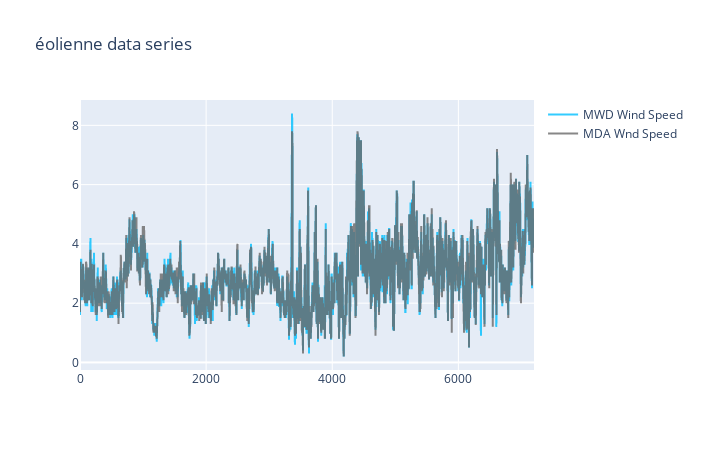

In [44]:
%matplotlib inline
nb_points=7200
x=time[0:nb_points]
fig = go.Figure()
fig.add_trace(go.Scatter(
                x=x,
                y=[item for item in df["MWD Wind Speed"][0:nb_points]],
                name="MWD Wind Speed",
                line_color='deepskyblue',
                opacity=0.8))

fig.add_trace(go.Scatter(
                x=x,
                y=[item for item in df["MDA Wnd Speed"][0:nb_points]],
                name="MDA Wnd Speed",
                line_color='dimgray',
                opacity=0.8))

# Use date string to set xaxis range
fig.update_layout(xaxis_range=[x[0],
                               x[nb_points-1]],
                  title_text="éolienne data series")
fig.show()

In [ ]:
vis = visdom.Visdom()
vis.plotlyplot(fig, win="mywin3")

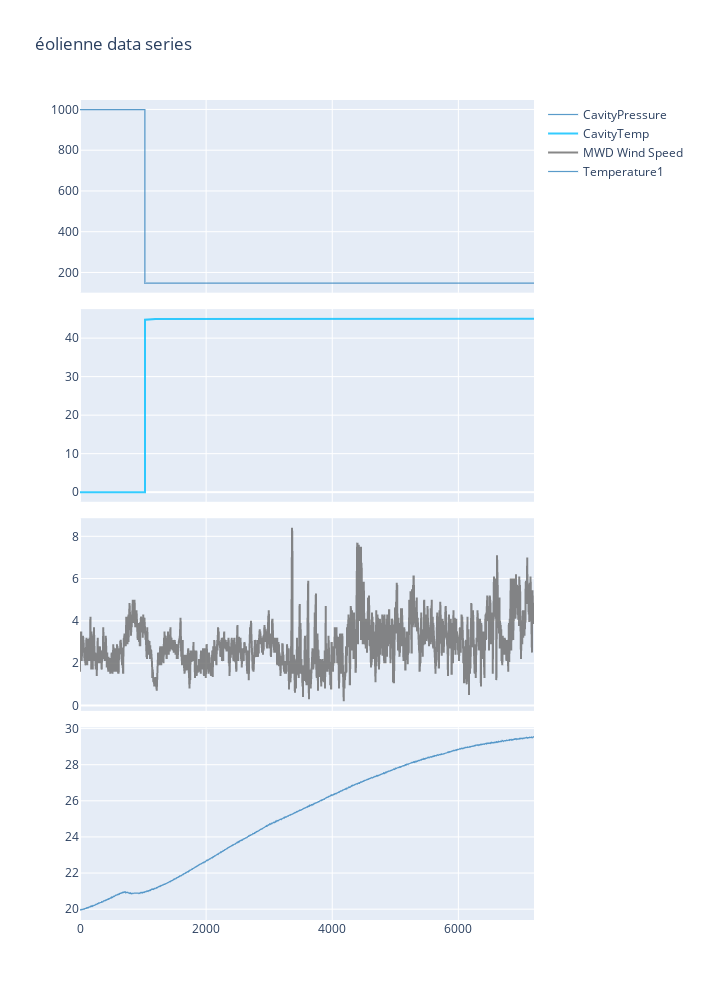

In [45]:
fig = make_subplots(
    rows=4, cols=1, shared_xaxes=True, vertical_spacing=0.02
)

fig.add_trace(go.Scatter(
                x=x,
                y=[item for item in df["CavityPressure"][0:nb_points]],
                name="CavityPressure",
                line_color='rgb(49,130,189)',
                line_width = 1.2,
                opacity=0.8),
              row=1, col=1)

fig.add_trace(go.Scatter(
                x=x,
                y=[item for item in df["CavityTemp"][0:nb_points]],
                name="CavityTemp",
                line_color='deepskyblue',
                line_width = 2,
                opacity=0.8),
              row=2, col=1)

fig.add_trace(go.Scatter(
                x=x,
                y=[item for item in df["MWD Wind Speed"][0:nb_points]],
                name="MWD Wind Speed",
                line_color='dimgray',
                opacity=0.8),
              row=3, col=1)

fig.add_trace(go.Scatter(
                x=x,
                y=[item for item in df["Temperature1"][0:nb_points]],
                name="Temperature1",
                line_color='rgb(49,130,189)',
                line_width = 1.2,
                opacity=0.8),
              row=4, col=1)

fig.update_layout(height=1000, width=1000,
                  title_text="éolienne data series")
fig.show()

In [ ]:
vis = visdom.Visdom()
vis.plotlyplot(fig, win="mywin3")

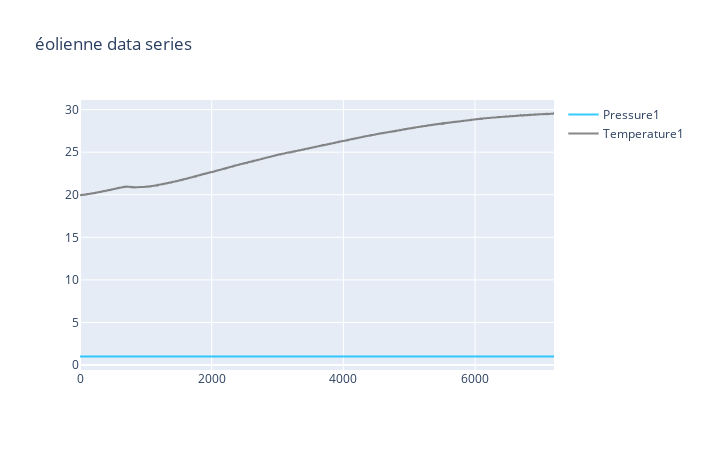

In [46]:
fig = go.Figure()
fig.add_trace(go.Scatter(
                x=x,
                y=[item for item in df["Pressure1"][0:nb_points]],
                name="Pressure1",
                line_color='deepskyblue',
                opacity=0.8))

fig.add_trace(go.Scatter(
                x=x,
                y=[item for item in df["Temperature1"][0:nb_points]],
                name="Temperature1",
                line_color='dimgray',
                opacity=0.8))

# Use date string to set xaxis range
fig.update_layout(xaxis_range=[x[0],
                               x[nb_points-1]],
                  title_text="éolienne data series")
fig.show()

### C/ Données de polution

## II/ Statistiques

In [ ]:
from sklearn.linear_model import LinearRegression


In [ ]:
lr_x=df['timestamp'].values.reshape(-1, 1) 
lr_y=df['Temperature1'].values.reshape(-1, 1) 

In [ ]:
lrModel = LinearRegression()
lrModel.fit(lr_x,lr_y)

In [ ]:
lrModel.score(lr_x,lr_y)

In [ ]:
alpha = lrModel.intercept_[0]
alpha

In [ ]:
beta = lrModel.coef_[0][0]
beta

In [ ]:
pred = alpha + beta*lr_x
pred

In [ ]:
temp = temp_ori - res
temp

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
temp.plot(ax=ax, lw=.5)
#ax.set_ylim(1.99, 2.02)
ax.set_xlabel('Date')
ax.set_ylabel('Mean temperature after treatement')

## III/ FFT, PSD : analyse en fréquence du signal

Notebook [FFTTuto](./fft.ipynb) illustrant l'utilisation des FFT et PSD sur des données temporelles


In [47]:
import scipy as sp
import scipy.fftpack

In [48]:
#Calcul fft
wspeed_p = df['MDA Wnd Speed']
wspeed_p

0       1.7
1       2.2
2       2.2
3       2.2
4       3.4
       ... 
7195    4.5
7196    4.5
7197    4.5
7198    4.6
7199    4.6
Name: MDA Wnd Speed, Length: 7200, dtype: float64

In [49]:
wspeed_p_fft = sp.fftpack.fft(wspeed_p.values)

In [50]:
#Calcul psd
wspeed_p_psd = np.abs(wspeed_p_fft) ** 2

In [51]:
fftfreq = sp.fftpack.fftfreq(len(wspeed_p_psd), 1. / 365*24*3600)

In [52]:
i = fftfreq > 0

Text(0, 0.5, 'PSD (dB)')

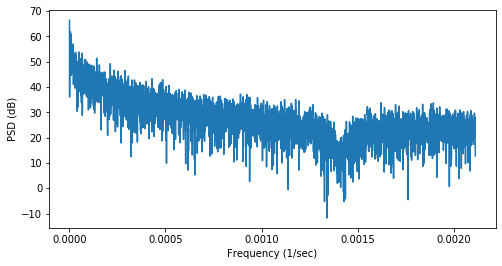

In [53]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(fftfreq[i], 10 * np.log10(wspeed_p_psd[i]))
#ax.plot(fftfreq[i], cavity_p_psd[i])
#ax.set_xlim(0, 5)
ax.set_xlabel('Frequency (1/sec)')
ax.set_ylabel('PSD (dB)')

In [54]:
#Extraction des fréquences les plus importantes (FFT tronquée)
wspeed_p_fft_bis = wspeed_p_fft.copy()
wspeed_p_fft_bis[np.abs(fftfreq) > 0.00001] = 0

Text(0, 0.5, 'Wind Speed')

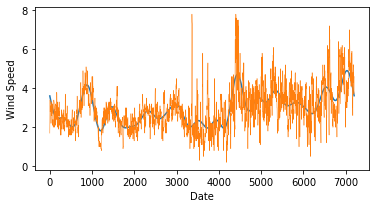

In [55]:
#Calcul de la courbe de température inverse de la FFT tronquée
wspeed_p_slow = np.real(sp.fftpack.ifft(wspeed_p_fft_bis))
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
#ax.plot_date(x, wspeed_p_slow, '-')
ax.plot(x, wspeed_p_slow, '-')
wspeed_p.plot(ax=ax, lw=.5)
#ax.set_xlim(df['timestamp'][0],
#            df['timestamp'][132])
#ax.set_ylim(-10, 40)
ax.set_xlabel('Date')
ax.set_ylabel('Wind Speed')

## IV/ Clustering


## V/ Apprentissage